In [1]:
import joblib
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import nibabel as nib
from os.path import join as pjoin
from sklearn.mixture import GaussianMixture
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
from matplotlib.font_manager import FontManager
from utils import get_roi_data, solve_GMM_eq_point, save2cifti

## position model inspection

In [2]:
wk_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
model_path = os.path.join(wk_dir, 'mappings')
subs = [f'sub-0{i+1}' for i in list(range(9))]
# subs.pop(2)
print(subs)

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09']


In [3]:
bfiletemplate = nib.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/template.dtseries.nii')
brain_models = bfiletemplate.header.get_index_map(1).brain_models
surface_brain_models = [bm for bm in brain_models if bm.model_type == 'CIFTI_MODEL_TYPE_SURFACE']

In [4]:
shared_voxels = set(np.arange(59412).tolist())
for i, sub in enumerate(subs):
    bmaskname = 'subjvis'
    layername = 'features3'
    modelname = 'RFmodels'
    submodelpath = pjoin(model_path, f'{sub}/{sub}_bm-{bmaskname}_layer-{layername}_{modelname}.pkl')
    submodel = joblib.load(submodelpath)
    print(f'{sub} voxel num: {len(submodel.keys())}')
    shared_voxels = set(submodel.keys()) & shared_voxels
    print(f'shared voxel num: {len(shared_voxels)}')

sub-01 voxel num: 6812
shared voxel num: 6812
sub-02 voxel num: 7633
shared voxel num: 5282
sub-03 voxel num: 5936
shared voxel num: 3926
sub-04 voxel num: 6470
shared voxel num: 3392
sub-05 voxel num: 5414
shared voxel num: 2933
sub-06 voxel num: 2968
shared voxel num: 1846
sub-07 voxel num: 6214
shared voxel num: 1702
sub-08 voxel num: 7020
shared voxel num: 1654
sub-09 voxel num: 7264
shared voxel num: 1640


In [26]:
np.stack([model.coef_ for model in submodel.values()], axis=0).shape

(7264, 192)

In [5]:
# ** project the selction onto the brain **
mask_path = pjoin(wk_dir, 'voxel_masks')
subs_voxel_masks = np.zeros((len(subs)+1, 59412))
shared_voxels = set(np.arange(59412).tolist())
mapnames = []
label_tables = []
labels_name = {0: 'notselected', 1:'selected'}
labels_rgba = {0: (0,0,0,0),
          1: (1,1,1,1)}

for i, sub in enumerate(subs):
   
    bmaskname = 'subjvis'
    layername = 'features3'
    modelname = 'RFmodels'
    submodelpath = pjoin(model_path, f'{sub}/{sub}_bm-{bmaskname}_layer-{layername}_{modelname}.pkl')
    submodel = joblib.load(submodelpath)
    print(f'{sub} voxel num: {len(submodel.keys())}')
    subs_voxel_masks[i,np.array(list(submodel.keys()))] = 1
    mapnames.append(sub)

    lbl_tb = nib.cifti2.Cifti2LabelTable()
    for key in np.unique(subs_voxel_masks):
        key = int(key)
        lbl_tb[key] = nib.cifti2.Cifti2Label(key, labels_name[key], *labels_rgba[key])
    label_tables.append(lbl_tb)

    shared_voxels = set(submodel.keys()) & shared_voxels
    print(f'shared voxel num: {len(shared_voxels)}')

mapnames.append('shared_voxels')
subs_voxel_masks[-1,np.array(list(shared_voxels))] = 1
lbl_tb = nib.cifti2.Cifti2LabelTable()
for key in np.unique(subs_voxel_masks):
    key = int(key)
    lbl_tb[key] = nib.cifti2.Cifti2Label(key, labels_name[key], *labels_rgba[key])
label_tables.append(lbl_tb)

save2cifti(pjoin(mask_path, 'nod_voxel_selection.dlabel.nii'),  
           subs_voxel_masks, surface_brain_models, map_names=mapnames, label_tables=label_tables)

sub-01 voxel num: 6812
shared voxel num: 6812
sub-02 voxel num: 7633
shared voxel num: 5282
sub-03 voxel num: 5936
shared voxel num: 3926
sub-04 voxel num: 6470
shared voxel num: 3392
sub-05 voxel num: 5414
shared voxel num: 2933
sub-06 voxel num: 2968
shared voxel num: 1846
sub-07 voxel num: 6214
shared voxel num: 1702
sub-08 voxel num: 7020
shared voxel num: 1654
sub-09 voxel num: 7264
shared voxel num: 1640


In [17]:
len(label_tables)

8

In [5]:
wk_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
sub = 'sub-03'
layername = 'features3'
model_path = os.path.join(wk_dir, 'mappings')

In [2]:
performance = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/retrainperformance/sub-03/sub-03_layer-features3_corrperformance-test-HM.npy')

In [2]:
corr = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/retrainperformance/sub-03/sub-03_layer-features3_corrperformance-test.npy') 

In [32]:
rf_model_files = [f'{sub}_layer-{layername}_RFmodels.pkl', 
                  f'{sub}_layer-{layername}_RFmodels-HM.pkl', 
                  f'{sub}_layer-{layername}_RFmodels-HM1.pkl']
rf_models = [joblib.load(os.path.join(model_path, sub, rf_model_file)) for rf_model_file in rf_model_files]
rf_model_params = [np.array([_.coef_ for __,_ in rf_model.items()]) for rf_model in rf_models] 

In [3]:
performance1 = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/retrainperformance/sub-03/sub-03_layer-features3_corrperformance-test.npy')
performance2 = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/retrainperformance/sub-03/sub-03_layer-features3_corrperformance-test-HM.npy')
voxel = np.nanargmax(performance1[4,:])
if voxel in rf_models[1].keys() and voxel in rf_models[2].keys():
    print(voxel)

In [53]:
voxel_rf_models = [rf_model[voxel] for rf_model in rf_models]

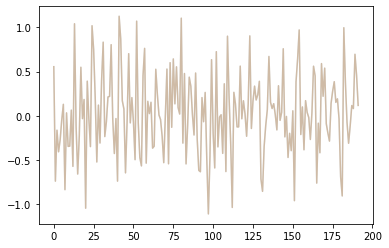

In [57]:
sorted_indices = np.argsort(voxel_rf_models[0].coef_)
for i in range(1,3):
    plt.plot(voxel_rf_models[i].coef_[sorted_indices], alpha=0.3)

In [20]:
vtc_areas = ['V8', 'PIT', 'FFC', 'VVC', ['VMV1', 'VMV2', 'VMV3'], ['LO1', 'LO2', 'LO3']]
# aggregate ROI vertices
roi_name = [__  for _ in [vtc_areas] for __ in _]
# form ROI mask
selection_mask = np.sum([get_roi_data(None, _) for _ in roi_name], axis=0)
# trsnfer to indices in cifti space
voxel_indices = np.where(selection_mask==1)[0]
voxel_indices.shape

(1530,)

In [8]:
# select ROI names
evc_pool = ['V1', 'V2', 'V3','V4']
# aggregate ROI vertices
roi_name = [__  for _ in [evc_pool] for __ in _]
# form ROI mask
selection_mask = np.sum([get_roi_data(None, _) for _ in roi_name], axis=0)
# trsnfer to indices in cifti space
voxel_indices = np.where(selection_mask==1)[0]
retino_path = os.path.join(wk_dir, 'retinoparams')
retinoR2 = np.load(os.path.join(retino_path, f'{sub}_layer-{layername}_params.npy'), allow_pickle=True)[0]['R2']
# calc the eqpoint
gmm = GaussianMixture(n_components=2)
gmm.fit(retinoR2[np.where(np.isnan(retinoR2)==0)].reshape(-1,1))
eqpoints = solve_GMM_eq_point(gmm.means_[0],gmm.means_[1],gmm.covariances_[0],gmm.covariances_[1])
if np.min(eqpoints) < np.min(gmm.means_) and np.max(eqpoints) < np.max(gmm.means_):
    eqpoint = eqpoints[eqpoints>np.min(eqpoints)]
elif np.min(eqpoints) > np.min(gmm.means_) and np.min(eqpoints) < np.max(gmm.means_):
    eqpoint = np.min(eqpoints)
print(f'{sub} GMM R2 thres at {eqpoint}')

# selected_voxel = [ _ for _ in voxel_indices if retinoR2[_] >= eqpoint]

sub-03 GMM R2 thres at [0.0968764]


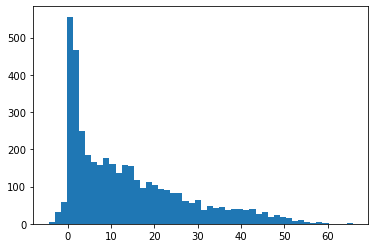

In [22]:
from scipy.stats import t

def tvalue_to_pvalue(t_value, df, two_tailed=True):
    """
    Convert a t-value to a p-value.
    
    Parameters:
    - t_value: t-value
    - df: Degrees of freedom (typically n-2 for correlation tests)
    - two_tailed: Boolean indicating if the test is two-tailed
    
    Returns:
    - p-value
    """
    if two_tailed:
        # If t-value is positive, we calculate the right tail and multiply by 2 for two-tailed test
        # If t-value is negative, we calculate the left tail and multiply by 2
        return 2 * (1 - t.cdf(abs(t_value), df))
    else:
        return 1 - t.cdf(abs(t_value), df)

# Test the function with the previous t-value and n-2 degrees of freedom
n_example = 27*27
t_value = retinoR2*np.sqrt((n_example -2)/(1 - retinoR2**2))
# log_p_value = np.log(tvalue_to_pvalue(t_value, n_example - 2) +1)
plt.hist(t_value, bins=50)
plt.show()

In [24]:
np.percentile(retinoR2[np.array(selected_voxel)], 67), np.argmax(retinoR2[np.array(selected_voxel)]), selected_voxel[np.argmax(retinoR2[np.array(selected_voxel)])]

(0.6278371544209688, 1101, 23117)

In [60]:
voxel = 23117
voxel_in_mask = np.where(np.array(voxel_indices)==voxel)[0][0]
voxel, voxel_in_mask

(23117, 1259)

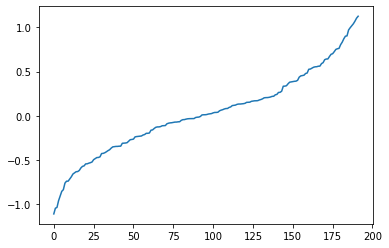

In [61]:
param = rf_models[1][voxel].coef_
sorted_param, sorted_indices = np.sort(param), np.argsort(param)
plt.plot(np.arange(192), sorted_param)
model_file = f'{sub}_layer-{layername}_models_fold1.pkl'
model = joblib.load(os.path.join(model_path, sub, model_file))
# model_params = [_.coef_ for __,_ in rf_model.items()] 

In [7]:
corrmap_path = os.path.join(wk_dir, 'corrmap')
corrmap_file = f'{sub}_layer-{layername}_corrmap-test.npy'
corrmap = np.load(os.path.join(corrmap_path, corrmap_file))
# voxel_corrmap = corrmap[:,:,voxel_in_mask]

In [31]:
performance2[4,np.where(np.isnan(performance2[4,:])==0)[0]].shape

(3052,)

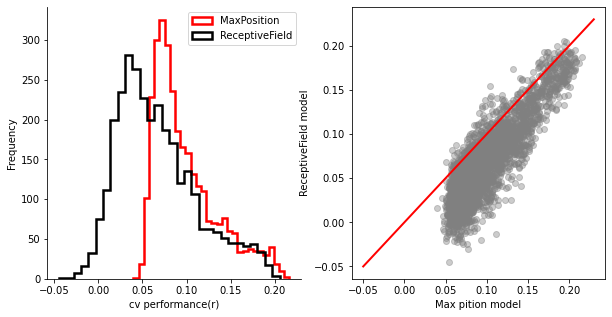

In [38]:
voxels_in_mask = []
for single_voxel in rf_models[1].keys():
    voxels_in_mask.append(np.where(voxel_indices==single_voxel)[0][0])

voxelcorr = np.max(corrmap, axis=(0,1))[np.array(voxels_in_mask)]
font_path = "./arial.ttf"  # 替换为你的字体文件路径
fm = FontManager()
fm.addfont(font_path)
fig, ax = plt.subplots(1,2,figsize=(10,5))
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.family'] = 'Arial'
ax[0].hist(voxelcorr, bins=30, color='red', histtype='step', label='MaxPosition', lw=2.5)
ax[0].hist(performance2[4,:], bins=30, color='black', histtype='step', label='ReceptiveField', lw=2.5)
ax[0].legend(loc='upper right')
ax[0].set_xlabel('cv performance(r)')
ax[0].set_ylabel('Frequency')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].scatter(voxelcorr,performance2[4,np.where(np.isnan(performance2[4,:])==0)[0]], color='gray', alpha=0.4 )
ax[1].plot([-0.05, 0.23], [-0.05, 0.23], color='red', lw=2)
ax[1].set_xlabel('Max pition model')
ax[1].set_ylabel('ReceptiveField model')
plt.show()

In [ ]:
np.percentile(voxel_corrmap, 95), np.percentile(voxel_corrmap, 60), np.percentile(voxel_corrmap, 40)

(0.16126894164272826, 0.04839564895765948, 0.033405839942230973)

In [63]:
# Get the colormap
cmap = plt.get_cmap("coolwarm")

# Select 5 colors from the colormap
colors = [cmap(i) for i in np.linspace(0, 1, 5)]
new_cmap = mcolors.ListedColormap(colors)
# 这里只是一个示例，您可能需要提供一个更具体的分类方法
def classify_pos(performance, corrmap):
    if performance > np.percentile(corrmap, 95):
        return 5
    elif performance > np.percentile(corrmap, 90):
        return 4
    elif performance > np.percentile(corrmap, 80):
        return 3
    elif performance > np.percentile(corrmap, 40):
        return 2
    else:
        return 1

classes = {pos : classify_pos(voxel_corrmap[pos], voxel_corrmap) for pos in model.keys()}

# 定义每个类别的颜色
color_map = {
    1: colors[0],
    2: colors[1],
    3: colors[2],
    4: colors[3],
    5: colors[4],
}

class1 = [pos for pos in model.keys() if classes[pos]==1] #np.where(np.array(list(classes.values()))==1)[0]
class2 = [pos for pos in model.keys() if classes[pos]==2]#np.where(np.array(list(classes.values()))==2)[0]
class3 = [pos for pos in model.keys() if classes[pos]==3]#np.where(np.array(list(classes.values()))==3)[0]
class4 = [pos for pos in model.keys() if classes[pos]==4]#np.where(np.array(list(classes.values()))==4)[0]
class5 = [pos for pos in model.keys() if classes[pos]==5]#np.where(np.array(list(classes.values()))==5)[0]


In [ ]:
np.argmax(voxel_corrmap)
np.unravel_index(np.argmax(voxel_corrmap), voxel_corrmap.shape)

(6, 19)

In [64]:
import random
random.seed(0)

np.random.seed(2023)
# class 5
# idx1, idx2 = np.random.choice(class5, 2)(6, 19), (8, 20) #
pos1, pos2 =  random.choice(class5), random.choice(class5)#list(classes.keys())[idx1], list(classes.keys())[idx2]
param1, param2 = model[pos1].coef_[voxel_in_mask, :], model[pos2].coef_[voxel_in_mask, :]

# class 4
# idx1, idx2 = np.random.choice(class4, 2) (6,23), (10,17)#
pos3, pos4 = random.choice(class4), random.choice(class4)#list(classes.keys())[idx1], list(classes.keys())[idx2]
param3, param4 = model[pos3].coef_[voxel_in_mask, :], model[pos4].coef_[voxel_in_mask, :]

# class 3
# idx1, idx2 = np.random.choice(class3, 2)
pos5, pos6 = random.choice(class3), random.choice(class3)#list(classes.keys())[idx1], list(classes.keys())[idx2]
param5, param6 = model[pos5].coef_[voxel_in_mask, :], model[pos6].coef_[voxel_in_mask, :]

# class 2
# idx1, idx2 = np.random.choice(class2, 2)
pos7, pos8 = random.choice(class2), random.choice(class2)#list(classes.keys())[idx1], list(classes.keys())[idx2]
param7, param8 = model[pos7].coef_[voxel_in_mask, :], model[pos8].coef_[voxel_in_mask, :]

# class 1
# idx1, idx2 = np.random.choice(class1, 2)
pos9, pos10 = random.choice(class1), random.choice(class1)#list(classes.keys())[idx1], list(classes.keys())[idx2]
param9, param10 = model[pos9].coef_[voxel_in_mask, :], model[pos10].coef_[voxel_in_mask, :]

In [65]:
pos1, pos2, pos3, pos4, pos5, pos6, pos7, pos8, pos9, pos10

((8, 21),
 (9, 17),
 (3, 20),
 (7, 24),
 (13, 21),
 (13, 17),
 (19, 16),
 (16, 13),
 (24, 1),
 (20, 2))

In [66]:
param9.shape

(192,)

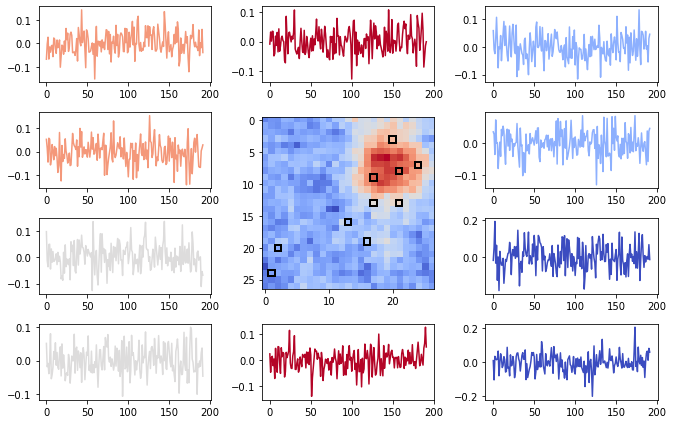

In [69]:
# Create a new figure
fig = plt.figure(figsize=(12, 6))

# Adjusted gridspec layout
gs = gridspec.GridSpec(4, 8, figure=fig)

# Create the central square subplot
central_square = fig.add_subplot(gs[1:3, 3:5])

# Create the surrounding rectangles
top_rect = fig.add_subplot(gs[0, 3:5])
bottom_rect = fig.add_subplot(gs[3, 3:5], sharex=top_rect)

# Adjusted positions for left and right rectangles
left_rects = [
    fig.add_subplot(gs[0, 1:3], sharex=top_rect),
    fig.add_subplot(gs[1, 1:3], sharex=top_rect),
    fig.add_subplot(gs[2, 1:3], sharex=top_rect),
    fig.add_subplot(gs[3, 1:3], sharex=top_rect)
]
right_rects = [
    fig.add_subplot(gs[0, 5:7], sharex=top_rect),
    fig.add_subplot(gs[1, 5:7], sharex=top_rect),
    fig.add_subplot(gs[2, 5:7], sharex=top_rect),
    fig.add_subplot(gs[3, 5:7], sharex=top_rect)
]

# center imshow
central_square.imshow(voxel_corrmap, cmap="coolwarm", vmin=np.min(voxel_corrmap),vmax=np.max(voxel_corrmap))
for pltpos in [pos1, pos2, pos3, pos4, pos5, pos6, pos7, pos8, pos9, pos10 ]:
    rect = patches.Rectangle((pltpos[1]-0.5, pltpos[0]-0.5), 1, 1, linewidth=2, edgecolor='black', facecolor='none')
    central_square.add_patch(rect)

channels = np.arange(192)
#

top_rect.plot(channels, param1, color=color_map[5])
bottom_rect.plot(channels, param2, color=color_map[5])

#
for rect, plotparam in zip(left_rects[0:2], [param3, param4]):
    rect.plot(channels, plotparam, color=color_map[4])
for rect, plotparam in zip(left_rects[2::], [param5, param6]):
    rect.plot(channels, plotparam, color=color_map[3])
for rect, plotparam in zip(right_rects[0:2], [param7, param8]):
    rect.plot(channels, plotparam, color=color_map[2])
for rect, plotparam in zip(right_rects[2::], [param9, param10]):
    rect.plot(channels, plotparam, color=color_map[1])
# Adjust the layout
plt.tight_layout()
plt.show()


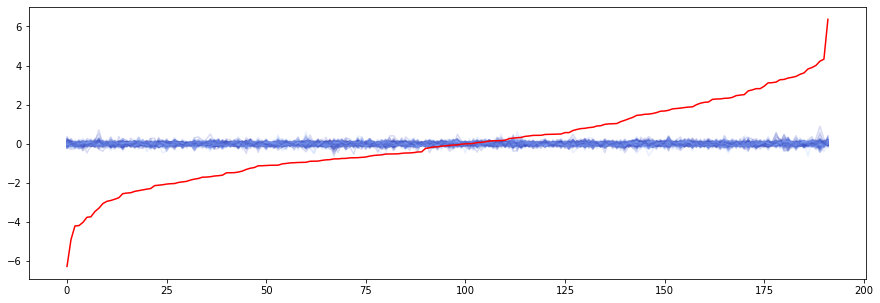

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
for pos, pos_model in model.items():
    cur_param = pos_model.coef_[voxel_in_mask, :]
    cur_param = cur_param[sorted_indices]
    class_name = classes[pos]
    plt.plot(np.arange(192), cur_param, color=color_map[class_name], alpha=0.2)
plt.plot(np.arange(192), rf_model_params[voxel_in_selection][sorted_indices], color='Red')
plt.show()

In [ ]:
# 加载模型并获取参数
model_files = ["path_to_your_model_1.pkl", "path_to_your_model_2.pkl", ...]
models = [joblib.load(file) for file in model_files]
parameters = [model.coef_ for model in models]  # 假设您使用的是线性回归模型，这里获取系数

# 根据预测能力分类模型


# 绘图
for params, cls in zip(parameters, classes):
    plt.plot(range(192), params, color=color_map[cls])

plt.xlabel("Features (0-191)")
plt.ylabel("Parameter Value")
plt.show()

## evaluation

In [89]:
modelfold0 = joblib.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/mappings/sub-03/sub-03_layer-features3_models_fold0.pkl')

In [91]:
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from utils import get_roi_data, train_data_normalization, alexnet_info

inputlayername = layername.replace('features','features.')
layer = {'name': inputlayername, 'size':alexnet_info[inputlayername]}
# 
image_activations_path = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/image_activations'
work_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
resp_path = os.path.join(work_dir, 'brain_response')

model_path = os.path.join(work_dir, 'mappings')
corrmap_path = os.path.join(work_dir, 'corrmap')
# load
brain_resp = np.load(os.path.join(resp_path, f'{sub}_imagenet_beta.npy'))
activations = np.load(os.path.join(image_activations_path, f'{sub}_{layername}.npy'))

# select ROI names
evc_pool = ['V1', 'V2', 'V3','V4']
# aggregate ROI vertices
roi_name = [__  for _ in [evc_pool] for __ in _]
# form ROI mask
selection_mask = np.sum([get_roi_data(None, _) for _ in roi_name], axis=0)
# trsnfer to indices in cifti space
voxel_indices = np.where(selection_mask==1)[0]

# collect resp in ROI
brain_resp = brain_resp[:, voxel_indices]

# normalization
norm_metric = 'session'
brain_resp = train_data_normalization(brain_resp, metric=norm_metric)
num_voxel = brain_resp.shape[-1]


X = activations
y = brain_resp
fold_indices = [(0, 1000)] #, (1000, 2000), (2000, 3000), (3000, 4000)
print('kfold start')
for fold, (start, end) in enumerate(fold_indices):
    X_train = np.concatenate([X[:start], X[end:]])
    y_train = np.concatenate([y[:start], y[end:]])
    
    X_val = X[start:end]
    y_val = y[start:end]
    
    models = {}  # 存储每个位置的线性回归模型
    
    all_predictions = np.zeros((X.shape[-2], X.shape[-1], end-start,  num_voxel))
    correlation_matrix = np.zeros((X.shape[-2], X.shape[-1], num_voxel))
    
    for i in range(layer['size']):
        for j in range(layer['size']):
            print(f'f-{fold}({i},{j})')
            lr = modelfold0[(i,j)]
            y_pred = lr.predict(X_val[:, :, i, j])
            all_predictions[i, j, :, :] = y_pred
            
    all_predictions = zscore(all_predictions, axis=-2)
    y_val = zscore(y_val, axis=0)
    correlation_matrix = np.mean(all_predictions*y_val, axis=-2)

kfold start
f-0(0,0)
f-0(0,1)
f-0(0,2)
f-0(0,3)
f-0(0,4)
f-0(0,5)
f-0(0,6)
f-0(0,7)
f-0(0,8)
f-0(0,9)
f-0(0,10)
f-0(0,11)
f-0(0,12)
f-0(0,13)
f-0(0,14)
f-0(0,15)
f-0(0,16)
f-0(0,17)
f-0(0,18)
f-0(0,19)
f-0(0,20)
f-0(0,21)
f-0(0,22)
f-0(0,23)
f-0(0,24)
f-0(0,25)
f-0(0,26)
f-0(1,0)
f-0(1,1)
f-0(1,2)
f-0(1,3)
f-0(1,4)
f-0(1,5)
f-0(1,6)
f-0(1,7)
f-0(1,8)
f-0(1,9)
f-0(1,10)
f-0(1,11)
f-0(1,12)
f-0(1,13)
f-0(1,14)
f-0(1,15)
f-0(1,16)
f-0(1,17)
f-0(1,18)
f-0(1,19)
f-0(1,20)
f-0(1,21)
f-0(1,22)
f-0(1,23)
f-0(1,24)
f-0(1,25)
f-0(1,26)
f-0(2,0)
f-0(2,1)
f-0(2,2)
f-0(2,3)
f-0(2,4)
f-0(2,5)
f-0(2,6)
f-0(2,7)
f-0(2,8)
f-0(2,9)
f-0(2,10)
f-0(2,11)
f-0(2,12)
f-0(2,13)
f-0(2,14)
f-0(2,15)
f-0(2,16)
f-0(2,17)
f-0(2,18)
f-0(2,19)
f-0(2,20)
f-0(2,21)
f-0(2,22)
f-0(2,23)
f-0(2,24)
f-0(2,25)
f-0(2,26)
f-0(3,0)
f-0(3,1)
f-0(3,2)
f-0(3,3)
f-0(3,4)
f-0(3,5)
f-0(3,6)
f-0(3,7)
f-0(3,8)
f-0(3,9)
f-0(3,10)
f-0(3,11)
f-0(3,12)
f-0(3,13)
f-0(3,14)
f-0(3,15)


KeyboardInterrupt: 

In [93]:
all_predictions = zscore(all_predictions, axis=-2)
y_val = zscore(y_val, axis=0)
correlation_matrix = np.mean(all_predictions*y_val, axis=-2)

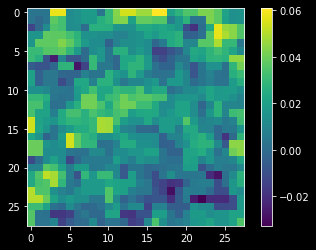

In [49]:
import matplotlib.pyplot as  plt
import numpy as np
from scipy.ndimage import median_filter
idx=4
# correlation_matrix = median_filter(correlation_matrix, size=(3, 3, 1))
cormap = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/corrmap/sub-01_bm-loandit-in-MMP_layer-raw-googlenet-inception3a_corrmap-test.npy')
plt.imshow(median_filter(cormap[:,:,idx], size=(2, 2)))
plt.colorbar()

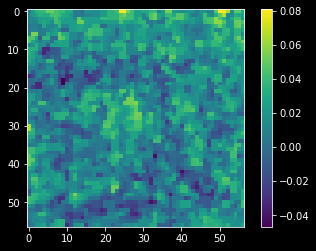

In [50]:
import matplotlib.pyplot as  plt
import numpy as np
from scipy.ndimage import median_filter
# correlation_matrix = median_filter(correlation_matrix, size=(3, 3, 1))
cormap = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/corrmap/sub-01_bm-loandit-in-MMP_layer-raw-googlenet-conv2_corrmap-test.npy')
plt.imshow(median_filter(cormap[:,:,idx], size=(2, 2)))
plt.colorbar()

## RF models params

In [3]:
wk_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline'
model_path = pjoin(wk_dir, 'build/mappings/')
activ_path = pjoin(wk_dir, 'prep/image_activations/')
resp_path = pjoin(wk_dir, 'prep/brain_response/')
gauss_path = pjoin(wk_dir, 'build/gaussianparams')

sub = 'sub-08'
mask_name = 'subjvis'
net_layer_dict = {'alexnet' : 'features3', 'googlenet' : 'googlenet-inception3a'}
net = 'googlenet'

layer_name = net_layer_dict['googlenet']
model_name = 'RFmodels'

modelname = f'{sub}_bm-{mask_name}_layer-{layer_name}_{model_name}.pkl'

mask_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/voxel_masks/'
mask_name = 'primaryvis-in-MMP'
primvis_mask = np.squeeze(nib.load(pjoin(mask_dir, f'nod-voxmask_{mask_name}.dlabel.nii')).get_fdata())
primivis_idx = np.where(primvis_mask == 1)[0]

selected_voxels =[ _ for _ in primivis_idx if _ in list(model.keys())]# list(googlemodel.keys()) 

# load models
load_model = lambda x : joblib.load(pjoin(model_path, sub, x))
model = load_model(modelname)

# concate weights
weights = np.stack([model[_].coef_ for _ in selected_voxels])